In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc

In [3]:
#load and process dataset
dataset = pd.read_csv("Ebuy_dataset/Outlet1.csv")
shii_mushroom_set = dataset[dataset["Product - English Name"] == 'Shiitake mushroom']
shii_mushroom_set = shii_mushroom_set[["month", "day", "Total Amount Sold", "Quantity of Order Received", "Quantity of Order Left", "Quantity of Order Placed"]]
shii_mushroom_set = shii_mushroom_set.iloc[:,:]
shii_mushroom_set = shii_mushroom_set.to_numpy()

#normalizaiton
mean = np.mean(shii_mushroom_set, axis = 0)
std = np.std(shii_mushroom_set, axis = 0)
shii_mushroom_set = (shii_mushroom_set - mean) / std

In [4]:
# paramerters 
epochs = 1048
inp_dim = 6              
out_dim = 1
mid_dim = 100
mid_layers = 1
#batch_size = 12 * 4 * 5
timestep = 60
mod_dir = '.'

In [5]:
shii_mushroom_set_x = shii_mushroom_set[:-1, :]
shii_mushroom_set_y = shii_mushroom_set[1:, -1]
assert shii_mushroom_set_x.shape[1] == inp_dim

In [6]:
#train_size = int(len(shii_mushroom_set_x) * 0.9)
train_size = len(shii_mushroom_set_x) - 32
train_x = shii_mushroom_set_x[:train_size]
train_y = shii_mushroom_set_y[:train_size]
train_x = train_x.reshape((train_size, inp_dim))
train_y = train_y.reshape((train_size, out_dim))

test_x = shii_mushroom_set_x.copy()
test_x[train_size:, -1] = 0

In [7]:
'''build model'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [8]:
'''train'''
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

batch_var_x = list()
batch_var_y = list()

for j in range(train_size - timestep):
    batch_var_x.append(var_x[j:j+timestep])
    batch_var_y.append(var_y[j:j+timestep])
    
from torch.nn.utils.rnn import pad_sequence
batch_var_x = pad_sequence(batch_var_x)
batch_var_y = pad_sequence(batch_var_y)

In [9]:
with torch.no_grad():
    weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

In [10]:
print("Training Start")
for epoch in range(epochs):
    out = net(batch_var_x)

    # loss = criterion(out, batch_var_y)
    loss = (out - batch_var_y) ** 2 * weights
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 64 == 0:
        print('Epoch: {:4}, weighted Loss: {:.5f}'.format(epoch, loss.item()))
        
torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
print("Save in:", '{}/net.pth'.format(mod_dir))

Training Start
Epoch:    0, weighted Loss: 0.72901
Epoch:   64, weighted Loss: 0.21523
Epoch:  128, weighted Loss: 0.07598
Epoch:  192, weighted Loss: 0.03525
Epoch:  256, weighted Loss: 0.02588
Epoch:  320, weighted Loss: 0.02042
Epoch:  384, weighted Loss: 0.01849
Epoch:  448, weighted Loss: 0.01822
Epoch:  512, weighted Loss: 0.01842
Epoch:  576, weighted Loss: 0.01496
Epoch:  640, weighted Loss: 0.01513
Epoch:  704, weighted Loss: 0.01353
Epoch:  768, weighted Loss: 0.01336
Epoch:  832, weighted Loss: 0.01245
Epoch:  896, weighted Loss: 0.01246
Epoch:  960, weighted Loss: 0.01165
Epoch: 1024, weighted Loss: 0.01176
Save in: ./net.pth


In [11]:
'''eval on test set'''
net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
net = net.eval()

In [12]:
test_x = shii_mushroom_set_x.copy()
test_x[train_size:, -1] = 0

test_x = test_x[:, np.newaxis, :]
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

In [13]:
eval_size = 1
zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)
test_y, hc = net.output_y_hc(test_x[:train_size], (zero_ten, zero_ten))

In [14]:
#test_y.shape

In [15]:
test_x[train_size + 1, 0, -1] = test_y[-1, 0, 0]

In [16]:
for i in range(train_size + 1, len(shii_mushroom_set_x) - 1):
    test_y, hc = net.output_y_hc(test_x[:i + 1], hc)               ### try test_x[i - timestep:i + 1]
    test_x[i + 1, 0, -1] = test_y[-1, 0, 0]
    test_x[i + 1, 0, 3] = test_y[-1, 0, 0]
    test_x[i + 1, 0, -2] = test_x[i + 1, 0, 3] - test_x[i + 1, 0, 2]

In [17]:
pred_y = test_x[1:, 0, -1]
pred_y = pred_y.cpu().data.numpy()

diff_y = pred_y[train_size:] - shii_mushroom_set_y[train_size:-1]
l1_loss = np.mean(np.abs(diff_y))
l2_loss = np.mean(diff_y ** 2)

pred_yy = pred_y[train_size:]
shii_mushroom_set_yy = shii_mushroom_set_y[train_size:-1]

unnor_ypred = pred_yy * std[-1] + mean[-1]
unnor_ytarg = shii_mushroom_set_yy * std[-1] + mean[-1]

personalized_loss = np.mean(np.abs([(unnor_ypred[i] - unnor_ytarg[i]) / unnor_ytarg[i] for i in range(len(pred_yy)) if unnor_ytarg[i] != 0]))
#personalized_loss = np.mean((unnor_ypred - unnor_ytarg) / unnor_ytarg)

print("L1: {:.3f}    L2: {:.3f}     personalized: {:.3f}".format(l1_loss, l2_loss, personalized_loss))

L1: 1.142    L2: 1.745     personalized: 3.253


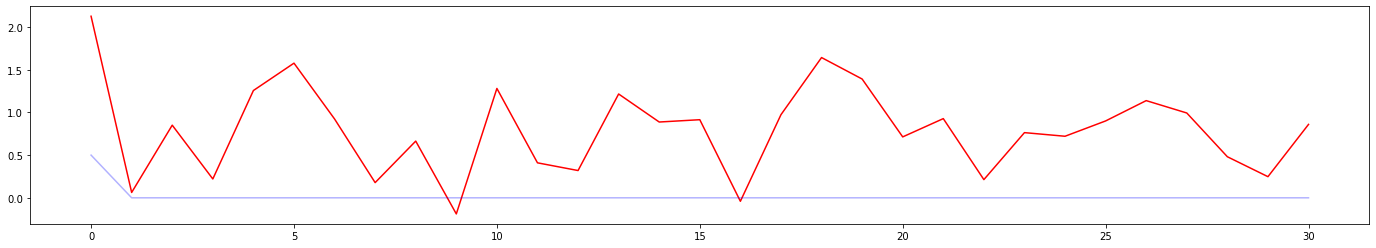

In [18]:
f, axes = plt.subplots(1,1, figsize = (24,4))
plt.plot(unnor_ypred, 'r', label='pred')
plt.plot(unnor_ytarg, 'b', label='real', alpha=0.3)
#plt.plot([train_size, train_size], [-1, 2], color='k', label='train | pred')
#plt.legend(loc='best')
plt.savefig('lstm_reg.jpg', dpi = 100)
plt.show()


In [27]:
unnor_ypred

array([ 2.1263871 ,  0.0626508 ,  0.85055965,  0.22071248,  1.2563959 ,
        1.5769079 ,  0.9231831 ,  0.17800498,  0.664005  , -0.18864119,
        1.280732  ,  0.40971214,  0.31941307,  1.2158408 ,  0.8876213 ,
        0.9147091 , -0.0405606 ,  0.97345215,  1.6425769 ,  1.391215  ,
        0.7134141 ,  0.92739767,  0.2130599 ,  0.76334834,  0.72090936,
        0.9002262 ,  1.138187  ,  0.99333215,  0.48096335,  0.24745947,
        0.85973513], dtype=float32)

### plot the trend of purchase_placed vs time

In [19]:
ProductList=["Enoki mushroom","Oyster mushroom","Shiitake mushroom","Pleurotus eryngii",
             "Crab mushroom","Bamboo shoots","Spinach",
             "Crown Daisy","Indian Lettuce","Fresh Lettuce","Chinese Cabbage","Baby Cabbage"]

In [20]:
index = 7
dataset = pd.read_csv("Ebuy_dataset/Outlet1.csv")
shii_mushroom_set = dataset[dataset["Product - English Name"] == ProductList[index]]
shii_mushroom_set = shii_mushroom_set[["month", "day", "Total Amount Sold", "Quantity of Order Received", "Quantity of Order Left", "Quantity of Order Placed"]]
shii_mushroom_set = shii_mushroom_set.iloc[:-31,:]
shii_mushroom_set = shii_mushroom_set.to_numpy()

#normalizaiton
#mean = np.mean(shii_mushroom_set, axis = 0)
#std = np.std(shii_mushroom_set, axis = 0)
#shii_mushroom_set = (shii_mushroom_set - mean) / std

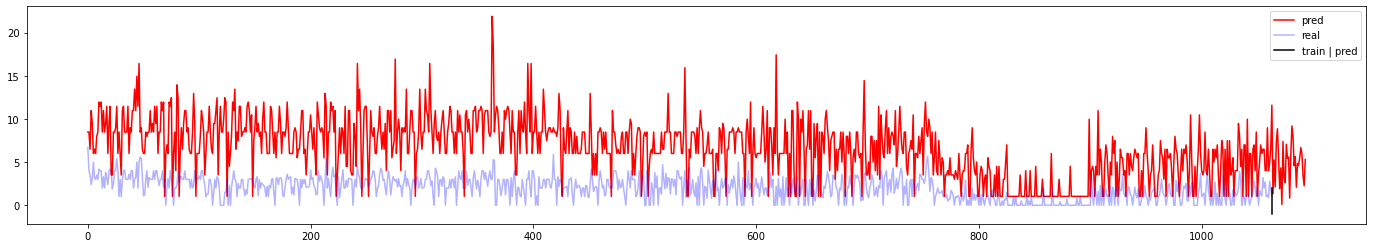

In [22]:
target = shii_mushroom_set[:,-1].tolist()
predict = pred_y * std[0] + mean[0]

f, axes = plt.subplots(1,1, figsize = (24,4))
plt.plot(predict, 'r', label='pred')
plt.plot(target, 'b', label='real', alpha=0.3)
#train_size = 385
plt.plot([train_size, train_size], [-1, 2], color='k', label='train | pred')
plt.legend(loc='best')
plt.savefig('lstm_reg.jpg', dpi = 100)
plt.show()